# Retinal-VesselNet under Tensorflow2 [OneForAll]

a segmentation model based on U-net for the task of retinal-vessel segmentation

**AUTHOR**: github @deeptrial

**PROJECT HOMEPAGE**: https://github.com/DeepTrial/Retina-VesselNet

**New Features**：
- support tensorflow2
- support google colab
- more comprehensive notes
- more concise code

## [Part-I] Environment Preparation

- If you are using Colab, Please remember to switch GPU mode before the following steps
- 如果在使用Google Colab，请确认已启用GPU加速

### 1. check the gpu  检查GPU

In [1]:
!nvidia-smi
import os
import datetime
os.environ['CUDA_VISIBLE_DEVICES'] = "1"     #use GPU-0 
%load_ext tensorboard

Tue Mar 16 14:25:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:05:00.0 Off |                  N/A |
| 33%   36C    P0    52W / 300W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:82:00.0 Off |                  N/A |
| 19%   24C    P0    55W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### 2. check the version of tensorflow 检查Tensorflow版本

We have tested under tensorflow2.3 

In [2]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2.3.0-dev20200523
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 3. install the requirements package 安装必要软件包

In [3]:
!pip install tqdm
!pip install matplotlib
!pip install opencv-python
!pip install tf-nightly
!pip install scikit-learn

!pip install onnxruntime
!pip install -U tf2onnx

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Requirement already up-to-date: tf2onnx in /home/ccxing/disk/anaconda3/envs/tf2/lib/python3.8/site-packages (1.8.3)


## [Part-II] Data Preparation

### [ONLY FOR COLAB USER] Upload the retinal dataset.

if you are using google colab, please follow this undering process (如果你正在使用Google Colab， 按照如下指示上传数据)：

- You can download the dataset from (Google drive):

- You can also download from (Baidu drive):

- Download everything you need and upload to your own google drive, the following code will connect to your google drive (如下代码将链接你个人的google drive，请确保你已将数据上传至云盘)


In [21]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


then you can mount the driver the following code, please **use your own path** to the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


cd to the path you uploaded, please **change the path** according to your uploading

Can you find the dataset file?


In [ ]:
%cd /content/drive/My Drive/Colab-Notebooks/Dataset
!ls
!unzip vessel-dataset.zip
!ls

### [FOR ALL USERS] Process and Generate the Training Image Patch 数据预处理与训练图像块生成

#### setting of dataset path 设置部分

- set the parameter and dataset dir (设定数据集的位置以及超参数)

In [17]:
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import cv2
import os
import random
import time
import shutil
from sklearn.utils import shuffle
%matplotlib inline

patch_size=48        # patch image size (图像块大小)
patch_num=1000        # sample number of one training image  (每张训练图像采样的图像块数量)
patch_threshold=25   # threshold for the patch, the smaller threshoold, the less vessel in the patch (采样阈值，数值越小，图像块内的血管面积越小)
TRAIN_OR_VAL=0.7
dataset_path='/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/'   # modify the dataset_path to your own dir（将dataset_path修改至你自己的路径）

train_dir=dataset_path+"training/"
test_dir=dataset_path+"test/"

train_image_dir=train_dir+"images/"
train_mask_dir=train_dir+"mask/"
train_groundtruth_dir=train_dir+"1st_manual/"
train_patch_dir=train_dir+"patch/"

test_image_dir=test_dir+"images/"
test_mask_dir=test_dir+"mask/"
test_groundtruth_dir=test_dir+"groundtruth/"
test_save_dir=test_dir+"pred_result/"

train_image_path_list=glob(train_image_dir+"*.tif")
test_image_path_list=glob(test_image_dir+"*.tif")


val_image_path_list=random.sample(train_image_path_list,int(len(train_image_path_list)*(1-TRAIN_OR_VAL)))
train_image_path_list=[i for i in train_image_path_list if i not in val_image_path_list]

print("number of training images:",len(train_image_path_list))
print("number of valid images:",len(val_image_path_list))
print("number of testing images:",len(test_image_path_list))

number of training images: 14
number of valid images: 6
number of testing images: 20


#### Image Preprocess （图像预处理）

In [4]:
def restrict_normalized(imgs,mask):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[2]):
        imgs_normalized[:,:,i] = ((imgs_normalized[:,:,i] - np.min(imgs_normalized[:,:,i])) / (np.max(imgs_normalized[:,:,i])-np.min(imgs_normalized[:,:,i])))*255
    return imgs_normalized

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  imgs_equalized = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_equalized[:,:,i] = clahe.apply(np.array(imgs[:,:,i], dtype = np.uint8))
  return imgs_equalized

def normalized(imgs):
  imgs_normalized =np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_normalized[:,:,i] =cv2.equalizeHist(imgs[:,:,i])
  return imgs_normalized

def adjust_gamma(imgs, gamma=1.0):
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  # apply gamma correction using the lookup table
  new_imgs = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    new_imgs[:,:,i] = cv2.LUT(np.array(imgs[:,:,i], dtype = np.uint8), table)
  return new_imgs

def preprocess(image,mask):
  
  assert np.max(mask)==1
  image=np.array(image)
  image[:,:,0]=image[:,:,0]*mask
  image[:,:,1]=image[:,:,1]*mask
  image[:,:,2]=image[:,:,2]*mask
  
  image=restrict_normalized(image,mask)
  image=clahe_equalized(image)
  image=adjust_gamma(image,1.2)
  image=image/255.0
  return image

#### Generate Image/Mask Patches （图像块生成部分）

In [5]:
def check_coord(x,y,h,w,patch_size):
  if x-patch_size/2>0 and x+patch_size/2<h and y-patch_size/2>0 and y+patch_size/2<w:
    return True
  return False

def image2patch(image_path,patch_num,patch_size,training=True,show=True):
  image_name=image_path.split("/")[-1].split("_")[0]

  image=plt.imread(image_path)

  groundtruth=plt.imread(train_groundtruth_dir+image_name+"_manual1.gif")
  groundtruth=np.where(groundtruth>0,1,0)

  mask=plt.imread(train_mask_dir+image_name+"_training_mask.gif")
  mask=np.where(mask>0,1,0)
  
  image=preprocess(image,mask)
  #image_binary=0.8*image[:,:,1]+0.2*image[:,:,2]  

  image_show=image.copy()
  groundtruth_show=np.zeros_like(image)
  groundtruth_show[:,:,0]=groundtruth.copy()
  groundtruth_show[:,:,1]=groundtruth.copy()
  groundtruth_show[:,:,2]=groundtruth.copy()

  sample_count=0
  sample_index=0
  
  sample_point=np.where(groundtruth==1)     # generate sample point (生成采样中心点)

  state = np.random.get_state()      # shuffle the coord (打乱顺序，模拟随机采样)
  np.random.shuffle(sample_point[0])
  np.random.set_state(state)
  np.random.shuffle(sample_point[1])

  patch_image_list=[]
  patch_groundtruth_list=[]

  while sample_count<patch_num and sample_index<len(sample_point[0]):
    x,y=sample_point[0][sample_index],sample_point[1][sample_index]
    if check_coord(x,y,image.shape[0],image.shape[1],patch_size):
      if np.sum(mask[x-patch_size//2:x+patch_size//2,y-patch_size//2:y+patch_size//2])>patch_threshold:     #select according to the threshold
       
        patch_image_binary=image[x-patch_size//2:x+patch_size//2,y-patch_size//2:y+patch_size//2,:]   # patch image
        patch_groundtruth=groundtruth[x-patch_size//2:x+patch_size//2,y-patch_size//2:y+patch_size//2]       # patch mask
        #patch_image_binary=np.asarray(0.25*patch_image[:,:,2]+0.75*patch_image[:,:,1])         # B*0.25+G*0.75, which enhance the vessel (增强血管的对比度)
        patch_groundtruth=np.where(patch_groundtruth>0,255,0)
    
        #patch_image_binary =cv2.equalizeHist((patch_image_binary*255.0).astype(np.uint8))/255.0
        
        patch_image_list.append(patch_image_binary)    # patch image
        patch_groundtruth_list.append(patch_groundtruth)             # patch mask
        if show:
          cv2.rectangle(image_show, (y-patch_size//2,x-patch_size//2,), (y+patch_size//2,x+patch_size//2), (0,1,0), 2)  #draw the illustration
          cv2.rectangle(groundtruth_show, (y-patch_size//2,x-patch_size//2,), (y+patch_size//2,x+patch_size//2), (0,1,0), 2)
        sample_count+=1
    
    if show:                                 # visualize the sample process(可视化采样过程，会很慢！)
      plt.figure(figsize=(15,15))
      plt.title("processing: %s"%image_name)
      plt.subplot(121)
      plt.imshow(image_show,cmap=plt.cm.gray)   # processd image
      plt.subplot(122)
      plt.imshow(groundtruth_show,cmap=plt.cm.gray)  #groundtruth of the image, patch is showed as the green square (绿色的方框表示采样的图像块)
      plt.show()
      display.clear_output(wait=True)
    sample_index+=1

  for i in range(len(patch_image_list)):
    if training==True:
        plt.imsave(train_patch_dir+image_name+"-"+str(i)+"-img.jpg",patch_image_list[i])
        #print(patch_mask_list[i])
        plt.imsave(train_patch_dir+image_name+"-"+str(i)+"-groundtruth.jpg",(patch_groundtruth_list[i]/225.0).astype(np.uint8),cmap = plt.cm.gray)
    else:
        plt.imsave(train_patch_dir+image_name+"_"+str(i)+"_val_img.jpg",patch_image_list[i])
        #print(patch_mask_list[i])
        plt.imsave(train_patch_dir+image_name+"_"+str(i)+"_val_groundtruth.jpg",(patch_groundtruth_list[i]/225.0).astype(np.uint8),cmap = plt.cm.gray)

# delete original patch images (删除已有的图像块数据)
if not os.path.exists(train_patch_dir):
  os.mkdir(train_patch_dir)
else:
  shutil.rmtree(train_patch_dir)
  os.mkdir(train_patch_dir)    

if not os.path.exists(test_save_dir):
  os.mkdir(test_save_dir)
    
# generate patch images (生成图像块数据)
for i in tqdm(range(len(train_image_path_list)),desc="Generate the training patches: "):
  image2patch(train_image_path_list[i],patch_num,patch_size,training=True,show=False)  # set show=True to visualize the sample process, which is much slower than show=False

for i in tqdm(range(len(val_image_path_list)),desc="Generate the val patches: "):
  image2patch(val_image_path_list[i],patch_num,patch_size,training=False,show=False)  # set show=True to visualize the sample process, which is much slower than show=False

Generate the val patches: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


## [Part-III] Model Defination 定义U-net模型

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import AveragePooling2D,Conv2DTranspose,Input,Add,Conv2D, BatchNormalization,LeakyReLU, Activation, MaxPool2D, Dropout, Flatten, Dense,UpSampling2D,Concatenate,Softmax

# define the model under eager mode

class LinearTransform(tf.keras.Model):
  def __init__(self, name="LinearTransform"):
    super(LinearTransform, self).__init__(self,name=name)

    self.conv_r=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)
    self.conv_g=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)
    self.conv_b=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)

    self.pool_rc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
    self.pool_gc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
    self.pool_bc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
        
    self.bn=BatchNormalization()
    self.sigmoid=Activation('sigmoid')
    self.softmax=Activation('softmax')

  def call(self, input,training=True):
    r,g,b=input[:,:,:,0:1],input[:,:,:,1:2],input[:,:,:,2:3]

    rs=self.conv_r(r)
    gs=self.conv_g(g)
    bs=self.conv_r(b)

    rc=tf.reshape(self.pool_rc(rs),[-1,1])
    gc=tf.reshape(self.pool_gc(gs),[-1,1])
    bc=tf.reshape(self.pool_bc(bs),[-1,1])

    merge=Concatenate(axis=-1)([rc,gc,bc])
    merge=tf.expand_dims(merge,axis=1)
    merge=tf.expand_dims(merge,axis=1)
    merge=self.softmax(merge)
    merge=tf.repeat(merge,repeats=48,axis=2)
    merge=tf.repeat(merge,repeats=48,axis=1)

    r=r*(1+self.sigmoid(rs))
    g=g*(1+self.sigmoid(gs))
    b=b*(1+self.sigmoid(bs))

    output=self.bn(merge[:,:,:,0:1]*r+merge[:,:,:,1:2]*g+merge[:,:,:,2:3]*b,training=training)
    return output

class ResBlock(tf.keras.Model):
  def __init__(self,out_ch,residual_path=False,stride=1):
    super(ResBlock,self).__init__(self)
    self.residual_path=residual_path
        
    self.conv1=Conv2D(out_ch,kernel_size=3,strides=stride,padding='same', use_bias=False,data_format="channels_last")
    self.bn1=BatchNormalization()
    self.relu1=LeakyReLU()#Activation('leaky_relu')
        
    self.conv2=Conv2D(out_ch,kernel_size=3,strides=1,padding='same', use_bias=False,data_format="channels_last")
    self.bn2=BatchNormalization()
        
    if residual_path:
      self.conv_shortcut=Conv2D(out_ch,kernel_size=1,strides=stride,padding='same',use_bias=False)
      self.bn_shortcut=BatchNormalization()
        
    self.relu2=LeakyReLU()#Activation('leaky_relu')
        
  def call(self,x,training=True):
    xs=self.relu1(self.bn1(self.conv1(x),training=training))
    xs=self.bn2(self.conv2(xs),training=training)

    if self.residual_path:
      x=self.bn_shortcut(self.conv_shortcut(x),training=training)
    #print(x.shape,xs.shape)
    xs=x+xs
    return self.relu2(xs)


class Unet(tf.keras.Model):
  def __init__(self):
    super(Unet,self).__init__(self)
    self.conv_init=LinearTransform()
    self.resinit=ResBlock(16,residual_path=True)
    self.up_sample=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resup=ResBlock(32,residual_path=True)
    
    self.pool1=MaxPool2D(pool_size=(2,2))

    self.resblock_down1=ResBlock(64,residual_path=True)
    self.resblock_down11=ResBlock(64,residual_path=False)
    self.pool2=MaxPool2D(pool_size=(2,2))

    self.resblock_down2=ResBlock(128,residual_path=True)
    self.resblock_down21=ResBlock(128,residual_path=False)
    self.pool3=MaxPool2D(pool_size=(2,2))

    self.resblock_down3=ResBlock(256,residual_path=True)
    self.resblock_down31=ResBlock(256,residual_path=False)
    self.pool4=MaxPool2D(pool_size=(2,2))

    self.resblock=ResBlock(512,residual_path=True)

    self.unpool3=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up3=ResBlock(256,residual_path=True)
    self.resblock_up31=ResBlock(256,residual_path=False)

    self.unpool2=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up2=ResBlock(128,residual_path=True)
    self.resblock_up21=ResBlock(128,residual_path=False)

    self.unpool1=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up1=ResBlock(64,residual_path=True)
    
    self.unpool_final=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock2=ResBlock(32,residual_path=True)
    
    self.pool_final=MaxPool2D(pool_size=(2,2))
    self.resfinal=ResBlock(32)
    
    self.conv_final=Conv2D(1,kernel_size=1,strides=1,padding='same',use_bias=False)
    self.bn_final=BatchNormalization()
    self.act=Activation('sigmoid')

  def call(self,x,training=True):
    x_linear=self.conv_init(x,training=training)
    x=self.resinit(x_linear,training=training)
    x=self.up_sample(x)
    x=self.resup(x,training=training)
    
    stage1=self.pool1(x)
    stage1=self.resblock_down1(stage1,training=training)
    stage1=self.resblock_down11(stage1,training=training)

    stage2=self.pool2(stage1)
    stage2=self.resblock_down2(stage2,training=training)
    stage2=self.resblock_down21(stage2,training=training)

    stage3=self.pool3(stage2)
    stage3=self.resblock_down3(stage3,training=training)
    stage3=self.resblock_down31(stage3,training=training)

    stage4=self.pool4(stage3)
    stage4=self.resblock(stage4,training=training)

    stage3=Concatenate(axis=3)([stage3,self.unpool3(stage4)])
    stage3=self.resblock_up3(stage3,training=training)
    stage3=self.resblock_up31(stage3,training=training)

    stage2=Concatenate(axis=3)([stage2,self.unpool2(stage3)])
    stage2=self.resblock_up2(stage2,training=training)
    stage2=self.resblock_up21(stage2,training=training)

    stage1=Concatenate(axis=3)([stage1,self.unpool1(stage2)])
    stage1=self.resblock_up1(stage1,training=training)
    
    x=Concatenate(axis=3)([x,self.unpool_final(stage1)])
    x=self.resblock2(x,training=training)
    
    x=self.pool_final(x)
    x=self.resfinal(x,training=training)
    
    seg_result=self.act(self.bn_final(self.conv_final(x),training=training))
    
    return x_linear,seg_result

## [Part-IV] Training Model 训练模型

### setting part （设置超参数）

In [7]:
EPOCHS=200
VAL_TIME=2
LR=0.0003
BATCH_SIZE=64

checkpoint_path=dataset_path+"ckpt/"
log_path=dataset_path+"logs/"

if not os.path.exists(checkpoint_path):
  os.mkdir(checkpoint_path)

if not os.path.exists(log_path):
  os.mkdir(log_path)

# use tensorboard to visualize the loss,acc,... (使用tensorboard观察各类指标变化)

### Training/Valid DataLoader (加载训练/测试数据)

In [8]:
def load_image_groundtruth(img_path,groundtruth_path):
  img=tf.io.read_file(img_path)
  img=tf.image.decode_jpeg(img,channels=3)
  img=tf.image.resize(img,[patch_size,patch_size])

  groundtruth=tf.io.read_file(groundtruth_path)
  groundtruth=tf.image.decode_jpeg(groundtruth,channels=1)
  
  # data argument (数据增强部分)
  if random.uniform(0,1)>=0.5:
    img=tf.image.flip_left_right(img)
    groundtruth=tf.image.flip_left_right(groundtruth)

#   if random.uniform(0,1)>=0.5:
#     seeds=random.uniform(0,1)
#     img=tf.image.central_crop(img,seeds)
#     groundtruth=tf.image.central_crop(groundtruth,seeds)

  img=tf.image.resize(img,[patch_size,patch_size])
  groundtruth=tf.image.resize(groundtruth,[patch_size,patch_size])
    
  img/=255.0
  groundtruth=(groundtruth+40)/255.0
  groundtruth=tf.cast(groundtruth,dtype=tf.uint8)

  return img,groundtruth


train_patch_img_path_list=sorted(glob(train_patch_dir+"*-*-img.jpg"))
train_patch_groundtruth_path_list=sorted(glob(train_patch_dir+"*-*-groundtruth.jpg"))
train_patch_img_path_list,train_patch_groundtruth_path_list=shuffle(train_patch_img_path_list,train_patch_groundtruth_path_list,random_state=0)

# make sure that img-list and mask-list is in order (确保打乱后的image-mask还是对应的) 
print(len(train_patch_img_path_list),len(train_patch_groundtruth_path_list))
print(train_patch_img_path_list[:2])
print(train_patch_groundtruth_path_list[:2])

val_patch_img_path_list=sorted(glob(train_patch_dir+"*_*_val_img.jpg"))
val_patch_groundtruth_path_list=sorted(glob(train_patch_dir+"*_*_val_groundtruth.jpg"))

print(val_patch_img_path_list[:2])
print(val_patch_groundtruth_path_list[:2])

# Training Dataloader
train_dataset=tf.data.Dataset.from_tensor_slices((train_patch_img_path_list,train_patch_groundtruth_path_list))
train_dataset=train_dataset.map(load_image_groundtruth,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1300).prefetch(BATCH_SIZE).batch(BATCH_SIZE)

# VAL Dataloader
val_dataset=tf.data.Dataset.from_tensor_slices((val_patch_img_path_list,val_patch_groundtruth_path_list))
val_dataset=val_dataset.map(load_image_groundtruth,num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.shuffle(buffer_size=1300).prefetch(BATCH_SIZE).batch(BATCH_SIZE)

14000 14000
['/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/28-132-img.jpg', '/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/32-781-img.jpg']
['/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/28-132-groundtruth.jpg', '/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/32-781-groundtruth.jpg']
['/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/23_0_val_img.jpg', '/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/23_100_val_img.jpg']
['/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/23_0_val_groundtruth.jpg', '/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/training/patch/23_100_val_groundtruth.jpg']


### Load and Compile the Model (加载并编译模型)

In [9]:
model=Unet()

# Learning rate and optimizer （学习率调整和优化器）
cosine_decay = tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=LR, first_decay_steps=12000,t_mul=1000,m_mul=0.5,alpha=1e-5)
optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay)

# loss function （损失函数）
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)

# metric record （性能指标记录器）
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc=tf.keras.metrics.Mean(name='train_acc')
current_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_acc=tf.keras.metrics.Mean(name='val_acc')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

# checkpoint （模型存档管理器）
ckpt = tf.train.Checkpoint(model=model)
#ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)
#ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))

# tensorboard writer （Tensorboard记录器）
log_dir=log_path+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_writer = tf.summary.create_file_writer(log_dir)

### Dice Loss & Dice Score

In [10]:
def dice(y_true,y_pred,smooth=1.):
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true,y_pred):
  return (1-dice(y_true,y_pred))

### Traing Step & Valid Step

training function and validation function

In [11]:

def train_step(step,patch,groundtruth):
  with tf.GradientTape() as tape:
        
    linear,pred_seg=model(patch,training=True)
    losses = dice_loss(groundtruth, pred_seg)
    
  # calculate the gradient （求梯度）
  grads = tape.gradient(losses, model.trainable_variables)
  # bp (反向传播) 
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  # record the training loss and accuracy (记录loss和准确率)
  train_loss.update_state(losses)
  train_acc.update_state(dice(groundtruth, pred_seg))



def val_step(step,patch,groundtruth):
 
  linear,pred_seg=model(patch,training=False)
  losses = dice_loss(groundtruth, pred_seg)
    
  # record the val loss and accuracy (记录loss和准确率)
  val_loss.update_state(losses)
  val_acc.update_state(dice(groundtruth, pred_seg))
  
  tf.summary.image("image",patch,step=step)
  tf.summary.image("image transform",linear,step=step)
  tf.summary.image("groundtruth",groundtruth*255,step=step)
  tf.summary.image("pred",pred_seg,step=step)
  log_writer.flush()


### Visualization Module （可视化模块）
- **visualize the model/graph (可视化模型结构)**

since we use keras subclasses to define the model, tensorboard is hard to use. we choose the netron(https://netron.app) to visualize the model. First, convert the saved model to the type of onnx, then open the website choose the generated onnx file. 

由于在定义模型时使用的是tensorflow动态图模型（eager），所以很多静态图方法都不支持，这里采用netron这个app进行模型可视化。首先，会将保存的模型转换成onnx格式，然后再netron网站或app中选择生成的onnx文件，就可以看到模型可视化结构

- **visualize the acc/loss (可视化模型指标)**

'%tensorboard' will launch the tensorbaord, you can find the training loss, training dice score, valid loss, valid dice score and valid image/groundtrurh/predicted images in it.

以下命令会启动tensorboard，你可以tensorbaord中看到训练误差/dice得分曲线，测试误差/dice得分曲线，以及预测的输入图像，类标图像和预测图像

In [12]:
# visualize the tensorflow2 model （可视化tensorflow模型）
input_arr = tf.random.uniform((1,patch_size,patch_size,1))
outputs = model(input_arr,training=False)
model.save("unet_model")
# convert tensorflow model to onnx （将tensorflow模型转化为onnx格式）
!python -m tf2onnx.convert --saved-model "./unet_model/" --output model.onnx


# lanuch the tensorboard (启动tensorboard)
# change the logdir path according to your settings (根据自身情况修改logdir)
%tensorboard --logdir  "/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/logs/" --bind_all

### Main function of training (训练主程序)

In [13]:
lr_step=0
last_val_loss=2e10
with log_writer.as_default():
  for epoch in range(EPOCHS):
    # renew the recorder （重置记录项）
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()
  
    # training （训练部分）
    for tstep, (patch,groundtruth) in enumerate(train_dataset):
      train_step(lr_step,patch,groundtruth)
    
      tf.summary.scalar("learning_rate", optimizer._decayed_lr(tf.float32).numpy(), step=lr_step)
      print('\repoch {}, batch {}, loss:{:.4f}, dice:{:.4f}'.format(epoch + 1, tstep, train_loss.result(), train_acc.result()),end="")
      lr_step+=1

    if (epoch + 1) % VAL_TIME == 0:
      #valid (验证部分)
      for vstep, (patch,groundtruth) in enumerate(val_dataset):
            
        val_step(lr_step,patch,groundtruth)
        
      print('\repoch {}, batch {}, train_loss:{:.4f}, train_dice:{:.4f}, val_loss:{:.4f}, val_dice:{:.4f}'.format(epoch + 1, vstep, train_loss.result(), train_acc.result(),val_loss.result(), val_acc.result()),end="")
      tf.summary.scalar("val_loss", val_loss.result(), step=epoch)
      tf.summary.scalar("val_acc", val_acc.result(), step=epoch)
    
      if val_loss.result()<last_val_loss:
        ckpt.save(checkpoint_path)
        last_val_loss=val_loss.result()
    print("")
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch)
    tf.summary.scalar("train_acc", train_acc.result(), step=epoch)
    log_writer.flush()


epoch 1, batch 218, loss:0.5127, dice:0.4873
epoch 2, batch 93, train_loss:0.4880, train_dice:0.5120, val_loss:0.5327, val_dice:0.4673
epoch 3, batch 218, loss:0.4691, dice:0.5309
epoch 4, batch 93, train_loss:0.4502, train_dice:0.5498, val_loss:0.4962, val_dice:0.5038
epoch 5, batch 218, loss:0.4306, dice:0.5694
epoch 6, batch 93, train_loss:0.4119, train_dice:0.5881, val_loss:0.4663, val_dice:0.5337
epoch 7, batch 218, loss:0.3929, dice:0.6071
epoch 8, batch 93, train_loss:0.3744, train_dice:0.6256, val_loss:0.4393, val_dice:0.5607
epoch 9, batch 218, loss:0.3572, dice:0.6428
epoch 10, batch 93, train_loss:0.3397, train_dice:0.6603, val_loss:0.4116, val_dice:0.5884
epoch 11, batch 218, loss:0.3233, dice:0.6767
epoch 12, batch 93, train_loss:0.3075, train_dice:0.6925, val_loss:0.3924, val_dice:0.6076
epoch 13, batch 218, loss:0.2926, dice:0.7074
epoch 14, batch 93, train_loss:0.2787, train_dice:0.7213, val_loss:0.3690, val_dice:0.6310
epoch 15, batch 218, loss:0.2659, dice:0.7341
epoc

epoch 121, batch 218, loss:0.0240, dice:0.9760
epoch 122, batch 93, train_loss:0.0237, train_dice:0.9763, val_loss:0.1920, val_dice:0.8080
epoch 123, batch 218, loss:0.0235, dice:0.9765
epoch 124, batch 93, train_loss:0.0231, train_dice:0.9769, val_loss:0.1917, val_dice:0.8083
epoch 125, batch 218, loss:0.0228, dice:0.9772
epoch 126, batch 93, train_loss:0.0224, train_dice:0.9776, val_loss:0.1908, val_dice:0.8092
epoch 127, batch 218, loss:0.0218, dice:0.9782
epoch 128, batch 93, train_loss:0.0219, train_dice:0.9781, val_loss:0.1910, val_dice:0.8090
epoch 129, batch 218, loss:0.0215, dice:0.9785
epoch 130, batch 93, train_loss:0.0213, train_dice:0.9787, val_loss:0.1921, val_dice:0.8079
epoch 131, batch 218, loss:0.0212, dice:0.9788
epoch 132, batch 93, train_loss:0.0210, train_dice:0.9790, val_loss:0.1928, val_dice:0.8072
epoch 133, batch 218, loss:0.0206, dice:0.9794
epoch 134, batch 93, train_loss:0.0204, train_dice:0.9796, val_loss:0.1909, val_dice:0.8091
epoch 135, batch 218, loss:

KeyboardInterrupt: 

## [Part-V] Test and Predict （测试模型）

### Prepare test images

In [14]:
# pad images （填充图像）
def padding_images(image,mask,stride):
    h,w=image.shape[:2]
    new_h,new_w=h,w
    while (new_h-patch_size)%stride!=0:
        new_h+=1
    while (new_w-patch_size)%stride!=0:
        new_w+=1
    pad_image=np.zeros((new_h,new_w,3))
    pad_image[:h,:w,:]=image
    
    pad_mask=np.zeros((new_h,new_w))
    pad_mask[:h,:w]=mask
    
    return pad_image,pad_mask

# images to patches （将图像分块）
def img2patch_list(image,stride=patch_size):
    patch_list=[]
    #image_binary=0.8*image[:,:,1:2]+0.2*image[:,:,2:3]  
    for j in range(0,image.shape[1]-patch_size+1,stride):
        for i in range(0,image.shape[0]-patch_size+1,stride):
            patch=image[i:i+patch_size,j:j+patch_size,:]
            patch_list.append(patch)
    return patch_list

# patches to image （将图像块拼成图像）
def patchlist2image(patch_list,stride,image_shape):
    result=np.zeros(image_shape[:2])
    sum_matrix=np.zeros(image_shape[:2])
    index_x,index_y=0,0
    for i in range(patch_list.shape[0]):
        patch=patch_list[i,:,:,0]
        #patch=np.where(patch>0.5,1,0)
        #print(patch)
        result[index_x:index_x+patch_size,index_y:index_y+patch_size]+=patch
        sum_matrix[index_x:index_x+patch_size,index_y:index_y+patch_size]+=1
        index_x+=stride
        if index_x+patch_size>image_shape[0]:
            index_x=0
            index_y+=stride
    return result/sum_matrix

### main func of test （测试主程序）

testing image: 8
post processing: 08
(584, 565)


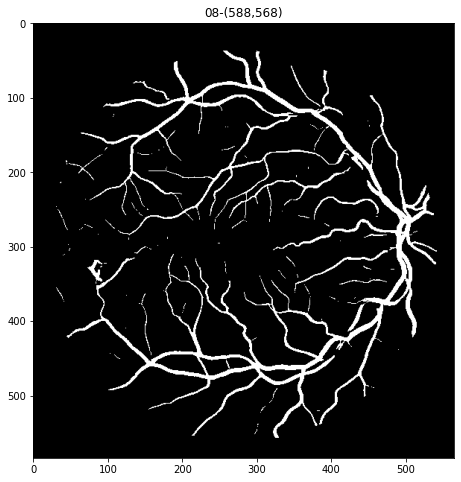

testing image: 13
post processing: 13
(584, 565)


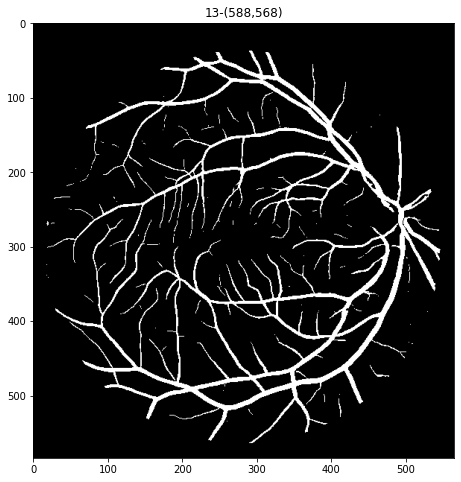

testing image: 10
post processing: 10
(584, 565)


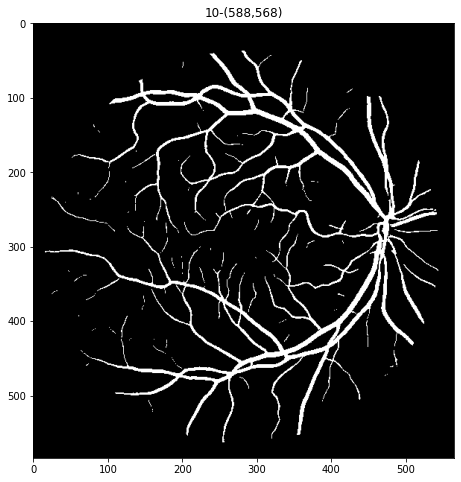

testing image: 1
post processing: 01
(584, 565)


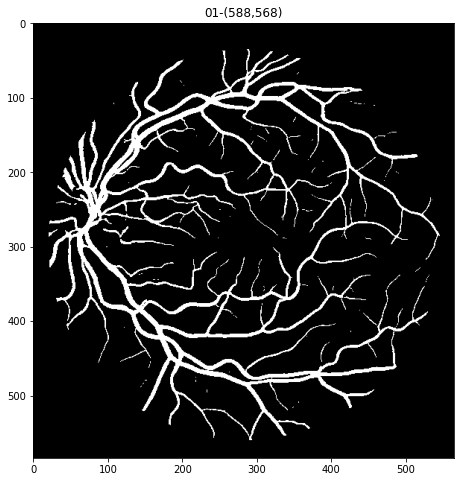

testing image: 3
post processing: 03
(584, 565)


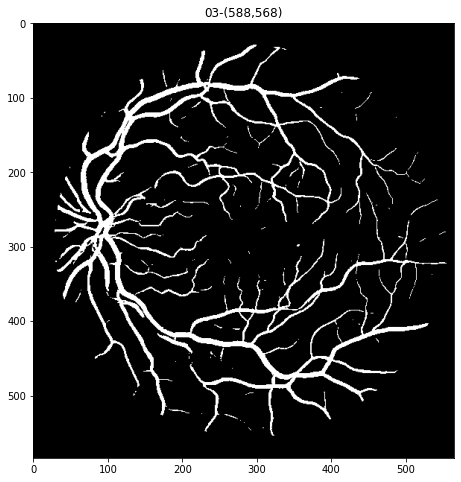

testing image: 14
post processing: 14
(584, 565)


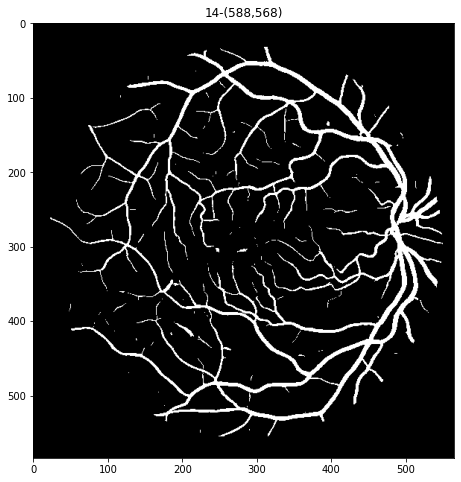

testing image: 18
post processing: 18
(584, 565)


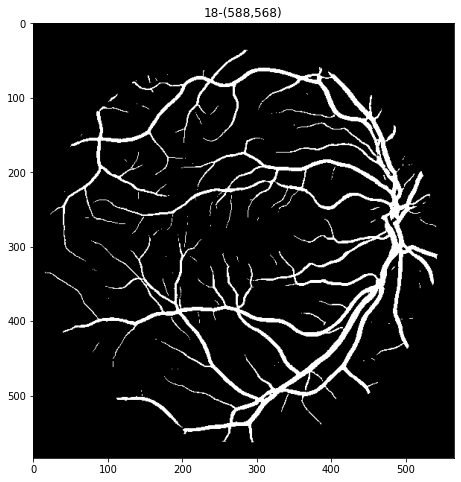

testing image: 15
post processing: 15
(584, 565)


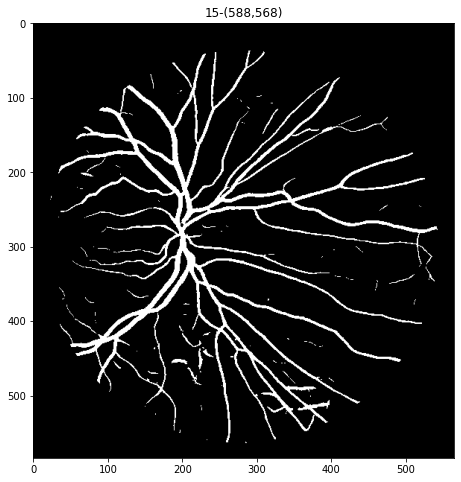

testing image: 19
post processing: 19
(584, 565)


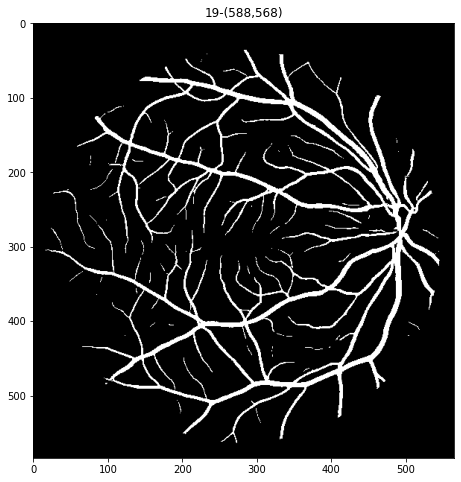

testing image: 20
post processing: 20
(584, 565)


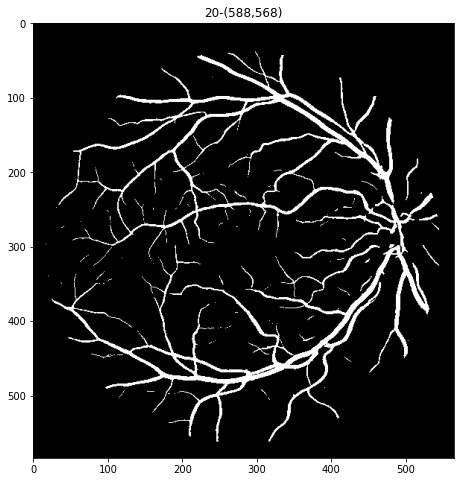

testing image: 16
post processing: 16
(584, 565)


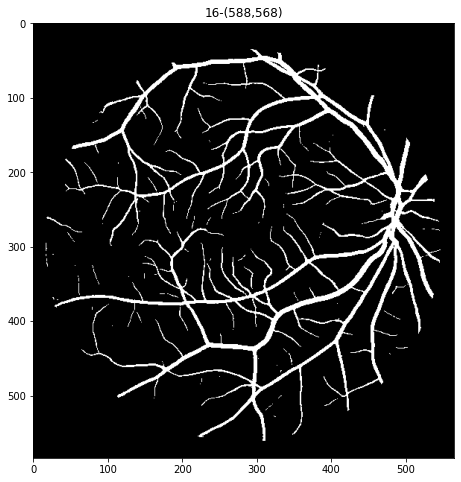

testing image: 5
post processing: 05
(584, 565)


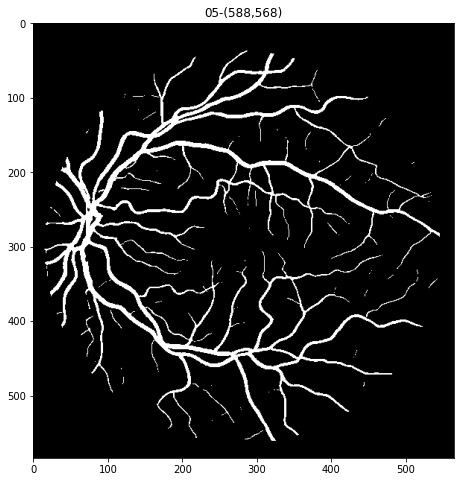

testing image: 12
post processing: 12
(584, 565)


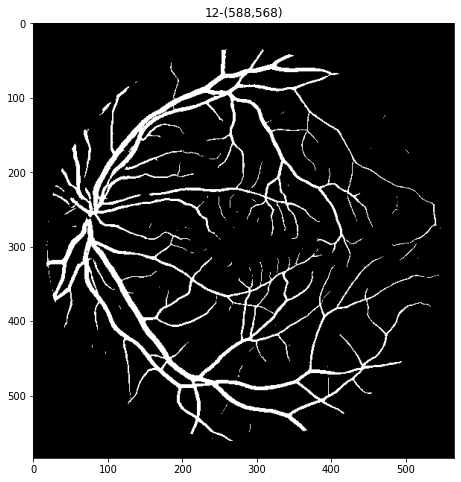

testing image: 9
post processing: 09
(584, 565)


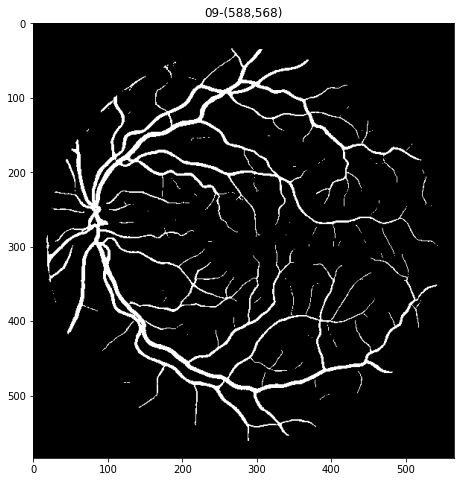

testing image: 17
post processing: 17
(584, 565)


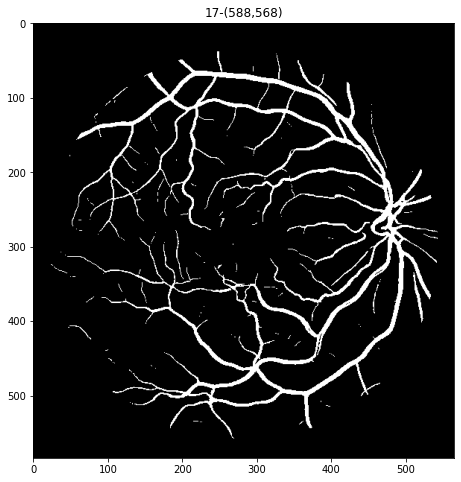

testing image: 7
post processing: 07
(584, 565)


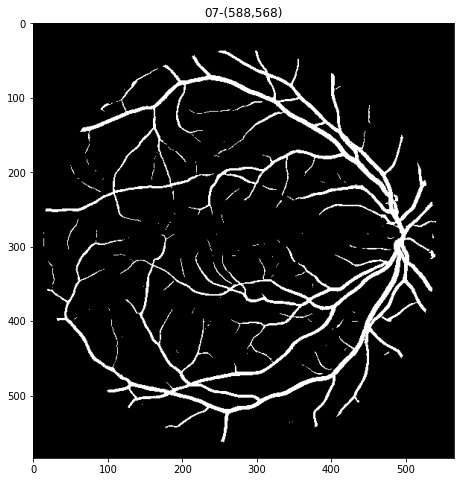

testing image: 6
post processing: 06
(584, 565)


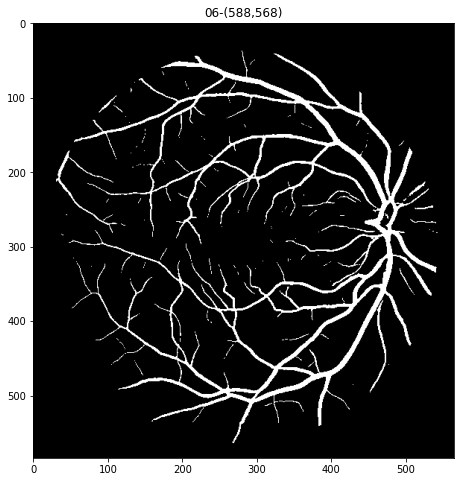

testing image: 2
post processing: 02
(584, 565)


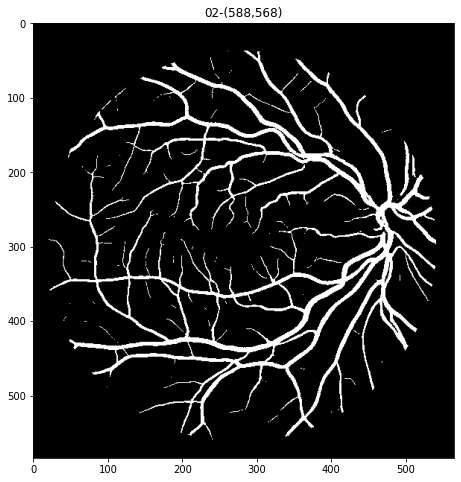

testing image: 11
post processing: 11
(584, 565)


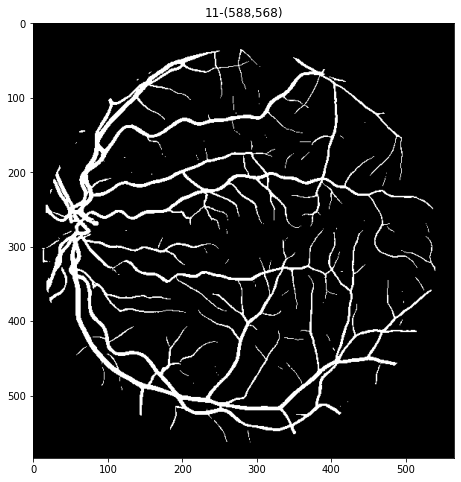

testing image: 4
post processing: 04
(584, 565)


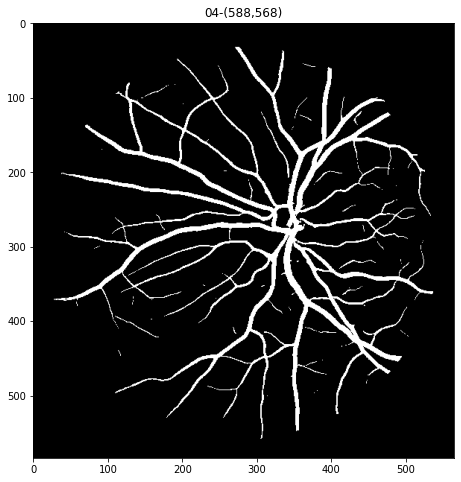

In [15]:
testmodel=Unet()
ckpts = tf.train.Checkpoint(model=testmodel)
ckpts.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

stride=5

def load_test_data(image):
  #image=tf.image.decode_jpeg(image,channels=1)
  #print(image.shape)
  image=tf.image.resize(image,[patch_size,patch_size])
  #image/=255.0
  return image

for i in range(len(test_image_path_list)):
  image_path=test_image_path_list[i]
  image_name=image_path.split("/")[-1].split("_")[0]
  
  # load and process test images （加载并预处理图像）
  image=plt.imread(image_path)
  original_shape=image.shape
  mask=plt.imread(test_mask_dir+image_name+"_test_mask.gif")
  mask=np.where(mask>0,1,0)
    
  # image to patches （图像分块）
  image,pad_mask=padding_images(image,mask,stride)
  image=preprocess(image,pad_mask)
  test_patch_list=img2patch_list(image,stride)

  # test dataloader （整合测试数据）
  test_dataset=tf.data.Dataset.from_tensor_slices(test_patch_list)
  test_dataset=test_dataset.map(load_test_data)
  test_dataset=test_dataset.batch(64)
  pred_result=[]
  
  # test process （测试）
  print("testing image:",int(image_name))
  for batch, patch in enumerate(test_dataset):
    _,pred=testmodel(patch,training=False)
    
    pred=pred.numpy()
    pred_result.append(pred)
  pred_result=np.concatenate(pred_result,axis=0)
  
  # patches to image （还原图像）
  print("post processing:",image_name)
  pred_image=patchlist2image(pred_result,stride,image.shape)
  
  pred_image=pred_image[:original_shape[0],:original_shape[1]]

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))#定义结构元素的形状和大小
  print(mask.shape)
  mask = cv2.erode(mask.astype(np.uint8), kernel)#膨胀操作

  pred_image=pred_image*mask
  pred_image=np.where(pred_image>0.5,1,0)
    
  # visualize the test result （可视化测试结果）
  plt.figure(figsize=(8,8))
  plt.title(image_name+"-("+str(image.shape[0])+","+str(image.shape[1])+")")
  plt.imshow(pred_image,cmap=plt.cm.gray)
  plt.show()

  plt.imsave(test_save_dir+str(int(image_name))+".png",pred_image,cmap = plt.cm.gray)
  

# [Part-VI] Evaluation (模型评估)


- sensitivity and specificity
- AUC and PR
- dice score

In [54]:
test_groundtruth_path_list=sorted(glob(test_groundtruth_dir+"*.gif"))
test_pred_path_list=sorted(glob(test_save_dir+"*.png"))

dice_list=[]
roc_list=[]
pr_list=[]
tpr_list=[]
tnr_list=[]
sum_tp=0
sum_tn=0
sum_fp=0
sum_fn=0

roc = tf.keras.metrics.AUC(num_thresholds=200,curve="ROC")
pr = tf.keras.metrics.AUC(num_thresholds=200,curve="PR")
recall=tf.keras.metrics.Recall()


tn=tf.keras.metrics.TrueNegatives()
tp=tf.keras.metrics.TruePositives()
fn=tf.keras.metrics.FalseNegatives()
fp=tf.keras.metrics.FalsePositives()

for idx in range(len(test_groundtruth_path_list)):
    name=test_groundtruth_path_list[idx].split("/")[-1].split(".")[0].split("_")[0]
    roc.reset_states()
    pr.reset_states()
    tn.reset_states()
    fn.reset_states()
    tp.reset_states()
    fp.reset_states()
    
    groundtruth=plt.imread(test_groundtruth_path_list[idx])
    preds=plt.imread(test_save_dir+str(int(name))+".png")
    groundtruth=np.array(groundtruth,dtype=np.float32)
    groundtruth=groundtruth/255.0
    
    roc.update_state(groundtruth,preds[:,:,0])   #png image is 4-channel
    pr.update_state(groundtruth,preds[:,:,0])
    tn.update_state(groundtruth,preds[:,:,0])
    tp.update_state(groundtruth,preds[:,:,0])
    fn.update_state(groundtruth,preds[:,:,0])
    fp.update_state(groundtruth,preds[:,:,0])
    
    dice_list.append(dice(groundtruth,preds[:,:,0]).numpy())
    roc_list.append(roc.result().numpy())
    pr_list.append(pr.result().numpy())
    
    current_tn=tn.result().numpy()
    current_tp=tp.result().numpy()
    current_fn=fn.result().numpy()
    current_fp=fp.result().numpy()
    
    sum_tp+=current_tp
    sum_tn+=current_tn
    sum_fp+=current_fp
    sum_fn+=current_fn
    
    tpr_list.append(current_tp/(current_tp+current_fn))
    tnr_list.append(current_tn/(current_tn+current_fp))
    
print("average dice score for all predict vessel masks:",np.mean(dice_list))
print("average AUC for all predict vessel masks:",np.mean(roc_list))
print("average PR for all predict vessel masks:",np.mean(pr_list))
print("average recall(sensitivity) for all predict vessel masks:",np.mean(tpr_list))
print("average specificity for all predict vessel masks:",np.mean(tnr_list))

average dice score for all predict vessel masks: 0.8041437
average AUC for all predict vessel masks: 0.87687457
average PR for all predict vessel masks: 0.6976475
average recall(sensitivity) for all predict vessel masks: 0.76676553
average specificity for all predict vessel masks: 0.9869835


- confusion matrix

confusion [[441966.0, 135979.0], [78461.0, 5942794.0]]


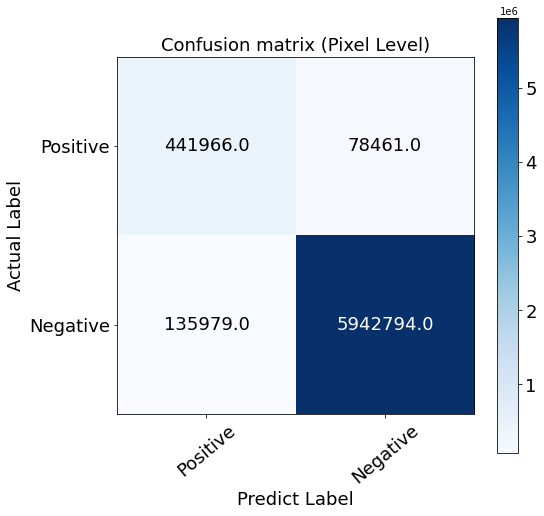

In [61]:
predict = ["Positive","Negative"]
actual = [ "Positive","Negative"]
classes = list(set(actual))
classes.sort(reverse=True)
confusion_matrix=[[sum_tp,sum_fn],[sum_fp,sum_tn]]
print("confusion",confusion_matrix)



plt.figure(figsize=(8,8))    
font_size=18
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
indices = range(len(confusion_matrix))
plt.xticks(indices, classes,rotation=40,fontsize=font_size)
plt.yticks([0.00,1.00], classes,fontsize=font_size)
plt.ylim(1.5 , -0.5)   

plt.title("Confusion matrix (Pixel Level)",fontdict={'weight':'normal','size': font_size})
plt.xlabel('Predict Label',fontsize=font_size)
plt.ylabel('Actual Label',fontsize=font_size)

for first_index in range(len(confusion_matrix)):
    for second_index in range(len(confusion_matrix[first_index])):
        if confusion_matrix[first_index][second_index]>2e6:
            text_color="w"
        else:
            text_color="black"
        plt.text(first_index, second_index, confusion_matrix[first_index][second_index],fontsize=font_size, color = text_color,verticalalignment='center',horizontalalignment='center',)

cb=plt.colorbar()
cb.ax.tick_params(labelsize=font_size)
plt.show()